## 실행O 까지 실행 X

In [11]:
# !pip install pandas_datareader
# !pip install linearmodels
# !pip install yfinance

In [1]:
import pandas as pd
import numpy as np
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
 
from linearmodels.asset_pricing import LinearFactorModel
 
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from pandas.tseries.offsets import *

#### 1. 주식 가격 데이터 다운로드

In [3]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

finance = ['DBC','EMLC', 'VTI' ,'VWO', 'EEM', 'TLT', 'USO', 'IEF', 'VWOB', 'GLD', 'DBA', 'SIVR']
rate = [25,15,10,10,7,7,7,6,4,3,2,2]
period = '5y'
interval='1mo'

def data_download(finance, period = period, interval=interval):
    price = yf.download(finance, period = period, interval=interval)
    price = price['Adj Close'].reset_index()
    price = price.iloc[:-1,:]    

    #Set index and remove the Day Name columns (index 설정 및 Day_Name column 삭제)
    price_month = price.set_index(['Date'])

    #Monthly returns (월 수익률)
    month_ret = price_month.pct_change(1).dropna()*100

    return  month_ret

### 월별 주식 수익률

In [5]:
month_ret = data_download(finance, period = period, interval=interval)
month_ret.head(10)

[*********************100%***********************]  12 of 12 completed


,DBA,DBC,EEM,EMLC,GLD,IEF,SIVR,TLT,USO,VTI,VWO,VWOB
Date,,,,,,,,,,,,
2018-01-01,0.373134,2.950036,9.939164,4.676918,3.234937,-1.848699,2.360771,-2.852920,8.076597,5.747319,9.076035,0.320684
2018-02-01,1.805637,-2.923981,-5.898485,-1.168069,-2.075990,-1.093930,-5.440568,-3.242889,-4.699535,-3.759621,-5.357142,-1.977484
2018-03-01,-1.877949,2.289157,0.541438,1.166429,0.632001,1.162875,-0.312697,2.866323,5.820536,-2.359718,-0.402787,0.477843
2018-04-01,2.339184,3.415783,-2.816900,-4.009638,-0.953975,-1.290301,-0.188204,-2.099884,5.423988,0.857421,-2.578122,-1.591273
2018-05-01,-0.207796,2.676544,-2.621484,-4.488105,-1.195921,0.967665,0.502828,1.997540,-1.811594,2.721323,-2.342370,-0.543410
2018-06-01,-6.142623,-1.941211,-5.165246,-3.950330,-3.614945,0.188171,-2.063789,0.633858,11.143913,0.278482,-5.402360,-0.920272
2018-07-01,-2.773159,-2.432124,4.207405,2.907704,-2.241891,-0.516100,-3.448276,-1.431066,-5.179287,3.756387,4.654734,2.016069
2018-08-01,-2.681116,0.753615,-3.767280,-6.745446,-2.138112,1.002710,-6.613757,1.314966,3.011207,3.432332,-4.193295,-1.773716
2018-09-01,-0.879258,3.394706,-0.579101,2.403143,-0.660735,-1.209243,0.708218,-2.865992,5.506461,-0.279868,-2.473820,1.618471


In [10]:
month_ret.to_csv('month_ret_v1.csv')

---

In [3]:
import pandas as pd
import numpy as np
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
 
from linearmodels.asset_pricing import LinearFactorModel
 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 월별 수익률 데이터 부르기
month_ret = pd.read_csv('month_ret_v1.csv',index_col=0)
rate = [25,15,10,10,7,7,7,6,4,3,2,2]

finance = ['DBC','EMLC','VTI','VWO','EEM','TLT','USO','IEF','VWOB','GLD','DBA','SIVR']

In [8]:
# pandas_datareader 라이브러리를 활용하여 Factor값 수집
ff_factor = 'F-F_Research_Data_Factors'
factor_data = web.DataReader(ff_factor, 'famafrench', start=month_ret.index[0])[0]
factor_data.head(10)

,Mkt-RF,SMB,HML,RF
Date,,,,
2018-01,5.57,-3.15,-1.33,0.12
2018-02,-3.65,0.23,-1.07,0.11
2018-03,-2.35,4.05,-0.23,0.11
2018-04,0.28,1.14,0.54,0.14
2018-05,2.65,5.26,-3.18,0.14
2018-06,0.48,1.15,-2.33,0.14
2018-07,3.19,-2.22,0.47,0.16
2018-08,3.44,1.12,-3.99,0.16
2018-09,0.06,-2.28,-1.69,0.15


In [9]:
### 주식수익률 Date 전처리(월까지만 살리기)
month_ret = month_ret.reset_index()
month_ret['Date'] = month_ret['Date'].apply(lambda x: x[:7])
month_ret = month_ret.set_index('Date') 

# 팩터 수익률 Date 전처리(문자형으로 변형)
factor_data = factor_data.reset_index()
factor_data['Date']=factor_data['Date'].astype(str)
factor_data = factor_data.set_index('Date')

In [14]:
# 무위험수익률을 제거하기
month_ret = month_ret.sub(factor_data.RF,axis=0)
factor_data = factor_data.drop('RF', axis=1)

In [16]:
betas = []
for ticker in month_ret:
    step = OLS(endog=month_ret.loc[factor_data.index, ticker], # 종속변수 
                exog=add_constant(factor_data) # 독립변수
                ).fit()
    betas.append(step.params.drop('const'))

betas = pd.DataFrame(betas, 
                     columns=factor_data.columns, 
                     index=month_ret.columns)

betas = betas.reset_index()
betas.columns = ['Name', 'Mkt-RF', 'SMB', 'HML']

In [18]:
invst_money = pd.DataFrame([finance,rate],index = ['Name','Invest']).T
betas = pd.merge(betas,invst_money, how='left', on='Name')

betas_all = betas.iloc[:,1:4].mul(betas['Invest']/betas['Invest'].sum(),axis=0).sum(axis=0)
betas_all = betas_all.to_frame()

In [19]:
betas_all

,0
Mkt-RF,0.510087
SMB,0.099138
HML,0.262876


In [69]:
def Factor_Model(month_ret, finance, rate):
    # 데이터 전처리
    ### 날짜 데이터 전처리(월까지만 살리기)
    month_ret = month_ret.reset_index()
    month_ret['Date'] = month_ret['Date'].apply(lambda x: x[:7])
    month_ret = month_ret.set_index('Date') 

    # pandas_datareader 라이브러리를 활용하여 Factor값 수집
    ff_factor = 'F-F_Research_Data_Factors'
    factor_data = web.DataReader(ff_factor, 'famafrench', start=month_ret.index[0])[0]

    # 날짜 데이터 전처리(문자형으로 변형)
    factor_data = factor_data.reset_index()
    factor_data['Date']=factor_data['Date'].astype(str)
    factor_data = factor_data.set_index('Date')

    # 무위험수익률을 제거하기
    month_ret = month_ret.sub(factor_data.RF,axis=0)
    factor_data = factor_data.drop('RF', axis=1)

    # 각 주식에 대해 회귀분석 진행
    betas = []
    for ticker in month_ret:
        step = OLS(endog=month_ret.loc[factor_data.index, ticker], # 종속변수 
                    exog=add_constant(factor_data) # 독립변수
                    ).fit()
        betas.append(step.params.drop('const'))

    betas = pd.DataFrame(betas, 
                         columns=factor_data.columns, 
                         index=month_ret.columns)
    
    betas = betas.reset_index()
    betas.columns = ['Name', 'Mkt-RF', 'SMB', 'HML']
    # 투자 비율에 맞게 가중합
    invst_money = pd.DataFrame([finance,rate],index = ['Name','Invest']).T
    betas = pd.merge(betas,invst_money, how='left', on='Name')

    betas_all = betas.iloc[:,1:4].mul(betas['Invest']/betas['Invest'].sum(),axis=0).sum(axis=0)
    betas_all = betas_all.to_frame()
    return betas_all

In [71]:
Factor_Model(month_ret, finance, rate)

,0
Mkt-RF,0.510087
SMB,0.099138
HML,0.262876


---

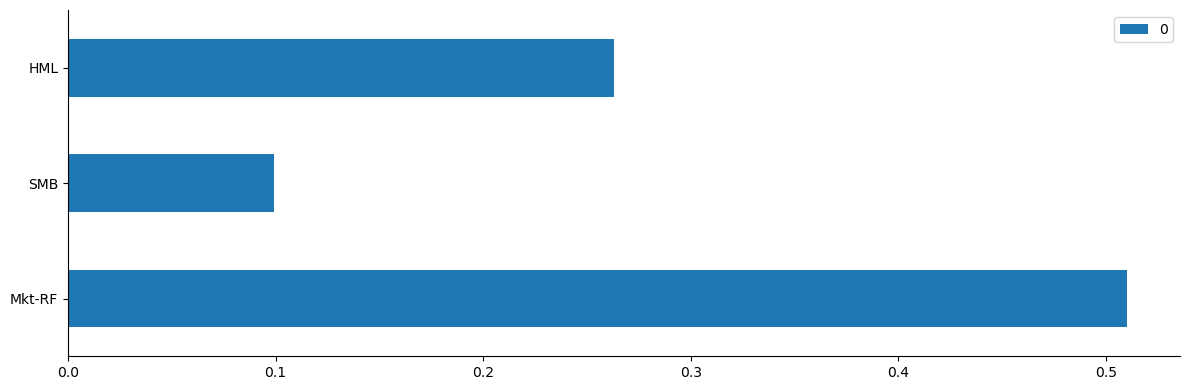

In [64]:
betas_all.plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout()
# mkt는 시장 포트의 베타
# SMB는 소형주 포트 수익률 - 대형주 포트 수익률 의 베타
# HML은 장부가치/시장가치 높은 포트 수익률 - 장부가치/시장가치 낮은 포트 수익률 의 베타

### 결과

#### case 1
- mkt이 0.007432이므로 전체 주식시장 인덱스에 대해 0.7%의 비율로 포트폴리오를 구성한다는 의미
- SMB 0.000943의 의미는 SMB에 대해 +값을 가지기 때문에 소형주 위주의 포트폴리오로 볼 수 있다는 것
    - 구체적으로는 대형주 0.09%를 팔고 소형주 0.09%로 구성한다는 의미
- HML 0.004775의 의미는 HML에 대해 +값을 가지기 때문에 가치주 위주의 포트폴리오로 볼 수 있다는 것
    - 이는 성장주 0.4%를 팔고 가치주 0.4%로 구성한다는 의미
    
전체적으로 보면, 시장수익률을 토대 위에 소형주 중에서 가치주 위주로 포트폴리오를 가져간다고 될 수 있음